### Required Headers

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import sys

from model.model import MV_MODEL

from dataset.TimeDataset import TimeDataset

from torch.utils.data import DataLoader

from preprocess.synthetic.multi_view_dataset import *
from utils.data_utils import get_MV_Data
from utils.time_utils import print_train_time
from utils.plot_utils import plot_losses
from utils.plot_utils import plot_multi_view_data_forecasted
from utils.plot_utils import plot_single_view_data_forecasted
from utils.generic_utils import create_directory

from constants.hyper_params import *

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print('Device : ',device)

Device :  cpu


### Random Seed

In [3]:
import random
    
seed = random.randint(0, 100)
#seed = 52, 91(trials), 29(best) # for SWaT
#seed = 76 # for HAI
#seed = 10
print('1. seed : ',seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

1. seed :  39


### Acquiring the Multi-View Time Series Data

In [4]:
MVTS_View_Wise_Data, labels = get_MV_Data()
#MVTS_View_Wise_Data = get_dataset()
#MVTS_View_Wise_Data = Sine_multi_view()
sequence_length = MVTS_View_Wise_Data[0].shape[1]
num_sequences = sequence_length - window_size + 1

(31, 153000)
(12, 153000)
(5, 153000)
(11, 153000)


### Splitting into training, validation and testing

In [5]:
#-------- Assume data to be split as [train, val, test] --------
train_seq_start = 0
train_seq_end = int((1 - (val_ratio + test_ratio)) * num_sequences)

val_seq_start = train_seq_end
val_seq_end = int((1 - test_ratio) * num_sequences)

test_seq_start = val_seq_end
test_seq_end = num_sequences - 1
#test_seq_end = num_sequences 

In [6]:
train_dataset = TimeDataset(MVTS_View_Wise_Data, window_size, train_seq_start, train_seq_end) 
train_loader = DataLoader(dataset = train_dataset, batch_size=batch, shuffle=False )

val_dataset = TimeDataset(MVTS_View_Wise_Data, window_size, val_seq_start, val_seq_end) 
val_loader = DataLoader(dataset = val_dataset, batch_size=batch, shuffle=False )

test_dataset = TimeDataset(MVTS_View_Wise_Data, window_size, test_seq_start, test_seq_end) 
test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=False )

print('Length of train dataloader : ',len(train_loader))
print('Length of validation dataloader : ',len(val_loader))
print('Length of test dataloader : ',len(test_loader))

Length of train dataloader :  120
Length of validation dataloader :  60
Length of test dataloader :  61196


### Model, Loss, Optimizer Initialization

In [7]:
num_views = len(MVTS_View_Wise_Data)
print('Number Of Views : ',num_views)

#-------- Getting the data view wise and the corresponding dimensions -------
Per_View_Dims = [] 

k = 0
for view in MVTS_View_Wise_Data :
 #----- Number Of Sensors per view -----
 N = view.shape[0]
 Per_View_Dims.append(N)
 print(N)

Number Of Views :  4
31
12
5
11


In [8]:
#mv_model = MV_MODEL(window_size, window_size//2,  Per_View_Dims) #.to(device) #7, 
mv_model = MV_MODEL(window_size, Per_View_Dims)
mv_model = mv_model.double()

criterion = nn.MSELoss()
optimizer = optim.SGD(mv_model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(mv_model.parameters(), lr=learning_rate)

In [9]:
#from torchsummary import summary
#summary(mv_model,input_size=(512, 19, 10))

### Hyperparameters, Losses

In [10]:
l = r"lamda1 : {}; lamda2 : {}; lamda3 : {}; lamda4 : {}; lamda5 : {}; ".format(lamdas[0],lamdas[1],lamdas[2],lamdas[3],lamdas[4])
print(l)

#---- Losses list to be plotted towards the end of training
train_loss_list = []
train_pred_loss_list = []
train_recons_loss_list = []
view_recons_loss_list = []
norms_list = []

losses = ()

lamda1 : 1; lamda2 : 1; lamda3 : 1; lamda4 : 0; lamda5 : 0; 


### Training & Validation Block

In [11]:
start_time=time.time()

for epoch in range(num_epochs):
 
   #Set the model to training mode
   mv_model.train()
 
   h_prev = []
 
   for idx, (x_curr, y) in enumerate(train_loader):   
        
      if idx == 0:
        for k in range(num_views):
          h_prev.append(x_curr[k].clone().detach())
      else :
          
        h_curr, x_pred, z, z_ = mv_model(h_prev, x_curr) 
          
        #losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas, device) 
        losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas) 
        
        total_loss = losses[3]
          
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        mv_model.zero_diagonal()
        
        h_prev = []
        for k in range(num_views):
          h_prev.append(h_curr[k].clone().detach())
        
   train_recons_loss_list.append(losses[0].item())
   view_recons_loss_list.append(losses[1].item())   
   train_pred_loss_list.append(losses[2].item())
   train_loss_list.append(losses[3].item())
   
   #Set the model to evaluation mode
   mv_model.eval()
 
   h_prev = []
   val_pred_data = []
   
   total_loss = 0.0
   val_steps = 0
   
   for idx, (x_curr, y) in enumerate(val_loader):   
        
      if idx == 0:
        for k in range(num_views):
          h_prev.append(x_curr[k].clone().detach())
      else :
          
        h_curr, x_pred, z, z_ = mv_model(h_prev, x_curr) 
        
        # ---- Validation prediction is primarily intended for synthetic data ----
        #if len(val_pred_data) == 0:
           #for k in range(num_views):
               #val_pred_data.append(x_pred[k])
        #else:
           #for k in range(num_views):
             #val_pred_data[k] = torch.cat([val_pred_data[k], x_pred[k]], dim=0)
             
        #losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas, device) #z_, 
        
        losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas)
        total_loss += losses[3].item()
        val_steps += 1
                
        mv_model.zero_diagonal()
        
        h_prev = []
        for k in range(num_views):
          h_prev.append(h_curr[k].clone().detach())
   
  
   val_loss = total_loss/val_steps
   
   if val_loss < best_val_loss:   
        #torch.save(mv_model.state_dict(), 'MVL_params.pt')
        best_val_loss = val_loss
        current_patience = 0
   else:
        current_patience += 1
  
   # Early stopping with patience parameter
   if current_patience >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  
   
   if((epoch+1)%10 == 0):
     #print('------------- Epoch : ',epoch+1, '--------------')
     L1 = f'Epoch : {epoch+1}; L1 = {losses[0].item():.6f}; L2 = {losses[1].item():.6f}; L3 = {losses[2].item():.6f}; L4 = {losses[3].item():.6f}; L5 = {losses[4].item():.6f}; L6 = {losses[5].item():.6f}'
     print(L1)
     
  
#----- Printing total training time ---------------
train_time = (time.time()-start_time)
print_train_time(train_time)

Epoch : 10; L1 = 0.470338; L2 = 0.060885; L3 = 0.015960; L4 = 0.547183; L5 = 0.116794; L6 = 1.506947
Epoch : 20; L1 = 0.137008; L2 = 0.067739; L3 = 0.017906; L4 = 0.222654; L5 = 0.193988; L6 = 1.635437
Epoch : 30; L1 = 0.085241; L2 = 0.008114; L3 = 0.008996; L4 = 0.102350; L5 = 0.229578; L6 = 1.723920
Epoch : 40; L1 = 0.078172; L2 = 0.003158; L3 = 0.008072; L4 = 0.089402; L5 = 0.251513; L6 = 1.800533
Epoch : 50; L1 = 0.050835; L2 = 0.003568; L3 = 0.008163; L4 = 0.062565; L5 = 0.259543; L6 = 1.856022
Epoch : 60; L1 = 0.042576; L2 = 0.003223; L3 = 0.008018; L4 = 0.053817; L5 = 0.260963; L6 = 1.907641
Epoch : 70; L1 = 0.032745; L2 = 0.003228; L3 = 0.007530; L4 = 0.043502; L5 = 0.263077; L6 = 1.979195
Epoch : 80; L1 = 0.027117; L2 = 0.003254; L3 = 0.009089; L4 = 0.039460; L5 = 0.265130; L6 = 2.024483
Epoch : 90; L1 = 0.023012; L2 = 0.003188; L3 = 0.011331; L4 = 0.037531; L5 = 0.266308; L6 = 2.043216
Epoch : 100; L1 = 0.020105; L2 = 0.003215; L3 = 0.010731; L4 = 0.034051; L5 = 0.267682; L6 

### Saving model and plotting losses

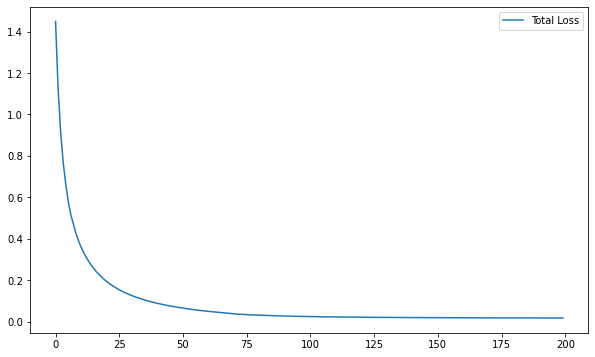

In [12]:
#----- Saving model --------------------
torch.save(mv_model.state_dict(), 'MVL_params.pt')

#----- Plotting losses ---------------
loss_dict = {}
#loss_dict['Reconstruction Loss'] = train_recons_loss_list
#loss_dict['View_Reconstruction Loss'] = view_recons_loss_list
#loss_dict['Prediction Loss'] = train_pred_loss_list
loss_dict['Total Loss'] = train_loss_list
plot_losses(epoch+1, loss_dict)

### Testing Block

In [13]:
#labels = labels[test_seq_start:]
#print('Labels shape: ',(labels.values).shape,'; type : ',type(labels.values))
mv_model_test = MV_MODEL(window_size, Per_View_Dims)
mv_model_test = mv_model_test.double()

mv_model_test.load_state_dict(torch.load('MVL_params.pt'))

inference_embeddings = []

In [14]:
from utils.time_utils import get_time

pred_list = []
loss_func = nn.MSELoss()

start_time=time.time()

mv_model_test.eval()

#------------------------ Inferencing ----------------------------

h_prev = []

for idx, (x_curr, y) in enumerate(test_loader):   
      
   with torch.no_grad(): 
      if idx == 0:
        for k in range(num_views):
          h_prev.append(x_curr[k])
      else :
        h_curr, x_pred, z, z_ = mv_model_test(h_prev, x_curr) 
        
        if len(inference_embeddings) == 0:
           for k in range(num_views):          
               inference_embeddings.append([h_curr[k]])
        else:
           for k in range(num_views):
               inference_embeddings[k].append(h_curr[k])
             #inference_embeddings[k] = torch.cat([inference_embeddings[k], h_curr[k]], dim=0)

        #--------------- Anomaly Scoring 1 ------------------
        pred_difference = 0
        recons_difference = 0
   
        for k in range(num_views):
          pred_difference = pred_difference + loss_func(y[k],x_pred[k])
          recons_difference = pred_difference + loss_func(x_curr[k],h_curr[k])
     
        #pred_difference = pred_difference / num_views
        #recons_difference = recons_difference / num_views
        pred_difference = pred_difference 
        recons_difference = recons_difference 
        total_difference = pred_difference + recons_difference
        #total_difference = (pred_difference + recons_difference)/2
        pred_list.append(total_difference)
        
        #--------------- Anomaly Scoring 2 ------------------
        #losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas, device)
        losses = mv_model_test.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas)
        total_difference = losses[0].item() + losses[1].item()
        #pred_list.append(total_difference)
        #pred_list.append(losses[3].item())
   
        h_prev = []
        for k in range(num_views):
          h_prev.append(h_curr[k]) 
    
#----- Printing total training time ---------------
test_time = (time.time()-start_time)
time_measure, formatted_time = get_time(test_time)
print('Inference time (',time_measure,') : ',formatted_time)
pred_len = len(pred_list)
print('Total number of predictions : ',pred_len)

Inference time ( mins ) :  3.00
Total number of predictions :  61195


### Performance Evaluation

## ROC-AUC

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#labels = labels.values
print(labels.shape)
unique_values = np.unique(labels)
#print(unique_values)
errors = np.array(pred_list)
print(errors.shape)

gt_labels = labels[-pred_len:]
fprs, tprs, thresholds = roc_curve(gt_labels, errors)
fprs = fprs.reshape(-1,1)
tprs = tprs.reshape(-1,1)
auc_score = auc(fprs, tprs) 
print(f'ROC AUC-Score : {auc_score:.6f}')

precision, recall, pr_thresholds = precision_recall_curve(gt_labels, errors)
pr_auc = auc(recall, precision)
print(f'PR AUC-Score : {pr_auc:.6f}')

(153000,)
(61195,)
ROC AUC-Score : 0.883818
PR AUC-Score : 0.053128


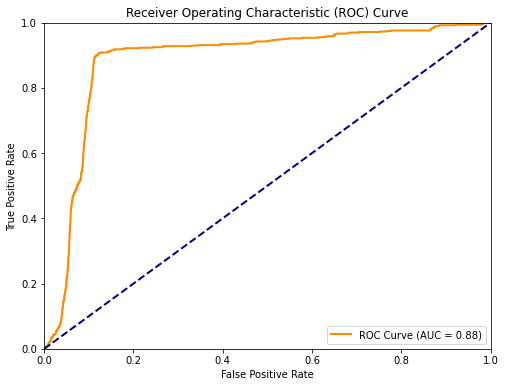

In [16]:
from utils.plot_utils import plot_roc_auc

plot_roc_auc(fprs, tprs, auc_score)

## PRECISION, RECALL, F1

In [17]:
# def get_pred_labels(errors, threshold):
#   pred_labels = np.zeros(len(errors))
#   pred_labels[errors > threshold] = 1
#   return pred_labels

In [18]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# fprs = fprs.reshape(-1,1)
# tprs = tprs.reshape(-1,1)
# thresholds = thresholds.reshape(-1,1)
# roc_samples = np.hstack((fprs, tprs, thresholds))

In [19]:
# allowed_fpr = 0.06
# filtered_roc = roc_samples[roc_samples[:, 0] <= allowed_fpr] #0.05
# print(f'Allowed FPR : {allowed_fpr:.6f}')
  
# sorted_indices = np.argsort(filtered_roc[:, 1])
# sorted_roc = filtered_roc[sorted_indices]
# des_FPR = sorted_roc[-1, 0]
# print(f'Desired FPR : {des_FPR:.6f}')

# des_threshold = sorted_roc[-1, 2]
# print(f'Desired Threshold : {des_threshold:.6f}')

# pred_labels = get_pred_labels(errors, des_threshold)

# pre = precision_score(gt_labels, pred_labels)
# rec = recall_score(gt_labels, pred_labels)
# f1 = f1_score(gt_labels, pred_labels)

In [20]:
# print(f'Precision : {pre:.6f}')
# print(f'Recall : {rec:.6f}')
# print(f'F1-Score : {f1:.6f}')

### Inference Embeddings

In [21]:
#print('Inference Embeddings :')

#for k in range(num_views):
    #print(len(inference_embeddings[k]))
    #print(inference_embeddings[k].shape)
    
#print(inference_embeddings[k][0].shape)

In [22]:
#print(inference_embeddings[4][0].shape)

In [23]:
# from utils.plot_utils import plot_tSNE

# plot_tSNE(inference_embeddings, pred_labels, gt_labels)